In [1]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from pytorch_tabular.utils import make_mixed_dataset

# %load_ext autoreload
# %autoreload 2

In [2]:
data, cat_col_names, num_col_names = make_mixed_dataset(
    task="classification", n_samples=10000, n_features=20, n_categories=4
)
train, test = train_test_split(data, random_state=42)
train, val = train_test_split(train, random_state=42)

# Importing the Library

In [3]:
from pytorch_tabular import TabularModel
from pytorch_tabular.models import GANDALFConfig
from pytorch_tabular.config import DataConfig, OptimizerConfig, TrainerConfig
from pytorch_tabular.models.common.heads import LinearHeadConfig

## Define the Configs

In [4]:
data_config = DataConfig(
    target=[
        "target"
    ],  # target should always be a list. Multi-targets are only supported for regression. Multi-Task Classification is not implemented
    continuous_cols=num_col_names,
    categorical_cols=cat_col_names,
)
trainer_config = TrainerConfig(
    auto_lr_find=True,  # Runs the LRFinder to automatically derive a learning rate
    batch_size=1024,
    max_epochs=100,
    accelerator="auto",  # can be 'cpu','gpu', 'tpu', or 'ipu'
)
optimizer_config = OptimizerConfig()

head_config = LinearHeadConfig(
    layers="",  # No additional layer in head, just a mapping layer to output_dim
    dropout=0.1,
    initialization="kaiming",
).__dict__  # Convert to dict to pass to the model config (OmegaConf doesn't accept objects)

model_config = GANDALFConfig(
    task="classification",
    gflu_stages=3,  # Number of stages in the GFLU block
    gflu_dropout=0.0,  # Dropout in each of the GFLU block
    gflu_feature_init_sparsity=0.1,  # Sparsity of the initial feature selection
    head="LinearHead",  # Linear Head
    head_config=head_config,  # Linear Head Config
    learning_rate=1e-3,
)


tabular_model = TabularModel(
    data_config=data_config,
    model_config=model_config,
    optimizer_config=optimizer_config,
    trainer_config=trainer_config,
    verbose=False,
)

## Training the Model 

In [5]:
tabular_model.fit(train=train, validation=val)

Seed set to 42


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
/home/manujosephv/miniconda3/envs/lightning_upgrade/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:639: Checkpoint directory saved_models exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/manujosephv/miniconda3/envs/lightning_upgrade/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing 

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.09120108393559097
Restoring states from the checkpoint path at /home/manujosephv/pytorch_tabular/docs/tutorials/.lr_find_fd8f0e95-a529-4577-9cd3-e484ff32cbef.ckpt
Restored all states from the checkpoint at /home/manujosephv/pytorch_tabular/docs/tutorials/.lr_find_fd8f0e95-a529-4577-9cd3-e484ff32cbef.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name             ┃ Type             ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ _backbone        │ GANDALFBackbone  │ 14.5 K │
│ 1 │ _embedding_layer │ Embedding1dLayer │     92 │
│ 2 │ _head            │ Sequential       │     60 │
│ 3 │ loss             │ CrossEntropyLoss │      0 │
└───┴──────────────────┴──────────────────┴────────┘
Trainable params: 14.6 K                                                        
Non-trainable params: 0                                                         
Total params: 14.6 K                                                            
Total estimated model params size (MB): 0                                       


Output()

## Evaluating the Model

In [6]:
result = tabular_model.evaluate(test)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9196000099182129     │
│         test_loss         │     0.203481063246727     │
└───────────────────────────┴───────────────────────────┘

/home/manujosephv/miniconda3/envs/lightning_upgrade/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


## Native Global Feature Importance

Some models like GANDALF, GATE, and FTTransformer have native feature importance, similar to the feature importance you get with GDBTs. 

In [7]:
tabular_model.feature_importance().sort_values("importance", ascending=False)

,Features,importance
0,cat_col_5,5.482856e-01
3,cat_col_19,3.333333e-01
1,cat_col_9,1.183810e-01
11,num_col_8,1.562194e-08
10,num_col_7,1.480499e-08
13,num_col_12,1.365922e-08
19,num_col_18,1.304813e-08
12,num_col_11,1.212310e-08
2,cat_col_10,1.032072e-08
9,num_col_6,1.018892e-08


<Axes: >

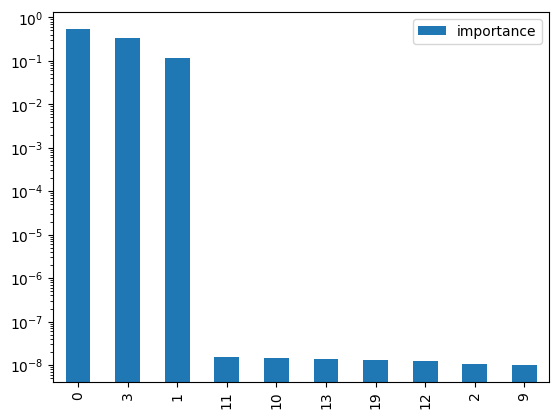

In [8]:
# bar plot, top 10 features
tabular_model.feature_importance().sort_values("importance", ascending=False).head(
    10
).plot.bar(logy=True)

## Local Feature Attributions

We can also use techniques like SHAP to get local feature attributions. This is a very powerful technique to explain the predictions of the model. We can use the `explain` method to get the local feature attributions for a given input.

`PyTorch Tabular` supports these methods from `captum` for all models except Tabnet, TabTransformer, and MDN:


- GradientShap: https://captum.ai/api/gradient_shap.html
- IntegratedGradients: https://captum.ai/api/integrated_gradients.html
- DeepLift: https://captum.ai/api/deep_lift.html
- DeepLiftShap: https://captum.ai/api/deep_lift_shap.html
- InputXGradient: https://captum.ai/api/input_x_gradient.html
- FeaturePermutation: https://captum.ai/api/feature_permutation.html
- FeatureAblation: https://captum.ai/api/feature_ablation.html
- KernelShap: https://captum.ai/api/kernel_shap.html

`PyTorch Tabular` also supports explaining single instances as well as batches of instances. But, larger datasets will take longer to explain. An exception is the `FeaturePermutation` and `FeatureAblation` methods, which is only meaningful for large batches of instances.

Most of these explainability methods require a baseline. This is used to compare the attributions of the input with the attributions of the baseline. The baseline can be a scalar value, a tensor of the same shape as the input, or a special string like "b|100" which means 100 samples from the training data. If the baseline is not provided, the default baseline (zero) is used.

### Single Instance

In [9]:
exp = tabular_model.explain(test.head(1), method="GradientShap", baselines="b|10000")

In [10]:
exp = exp.T.sort_values(0, ascending=False)
exp.columns = ["GradientSHAP"]
exp.index.name = "Features"
exp.reset_index(inplace=True)
exp["colors"] = "red"
exp.loc[exp["GradientSHAP"] > 0, "colors"] = "green"

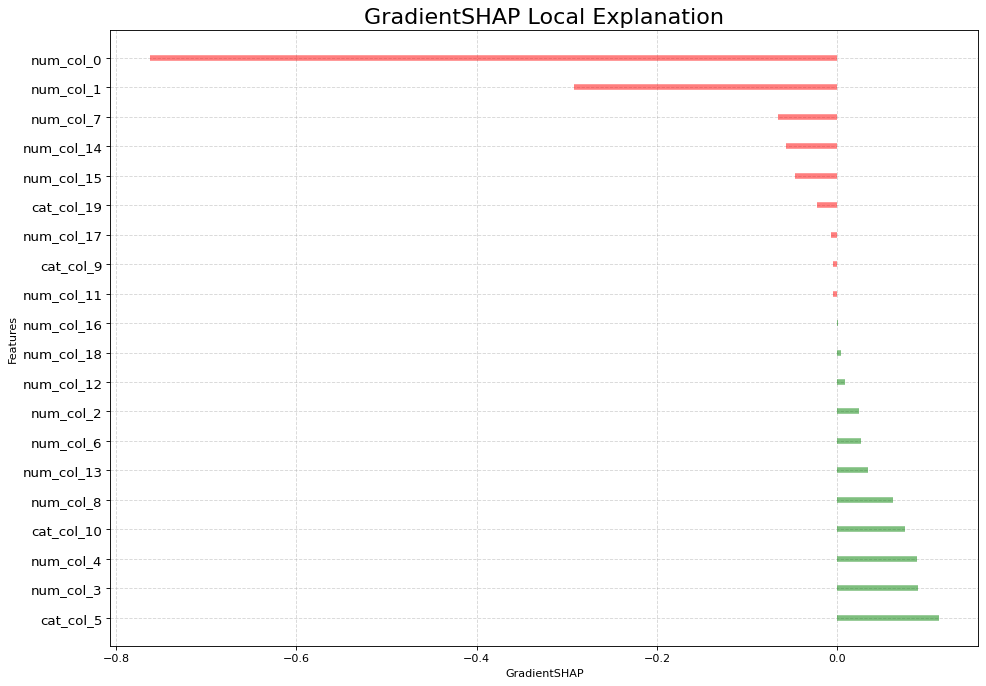

In [11]:
# Draw plot
plt.figure(figsize=(14, 10), dpi=80)

# Plotting the horizontal lines
plt.hlines(
    y=exp.index,
    linewidth=5,
    xmin=0,
    xmax=exp.GradientSHAP,
    colors=exp.colors.values,
    alpha=0.5,
)
# Decorations
# Setting the labels of x-axis and y-axis
plt.gca().set(ylabel="Features", xlabel="GradientSHAP")

# Setting Date to y-axis
plt.yticks(exp.index, exp.Features, fontsize=12)

# Title of Bar Chart
plt.title("GradientSHAP Local Explanation", fontdict={"size": 20})

# Optional grid layout
plt.grid(linestyle="--", alpha=0.5)

# Displaying the Diverging Bar Chart
plt.show()

### Multiple Instances

In [12]:
exp = tabular_model.explain(
    test[test.cat_col_19 == 3], method="GradientShap", baselines="b|10000"
)

In [13]:
exp.head()

,num_col_0,num_col_1,num_col_2,num_col_3,num_col_4,num_col_6,num_col_7,num_col_8,num_col_11,num_col_12,num_col_13,num_col_14,num_col_15,num_col_16,num_col_17,num_col_18,cat_col_5,cat_col_9,cat_col_10,cat_col_19
0,-1.724874,-1.447601,0.005033,-0.023054,0.019009,0.008514,-0.083980,0.004687,-0.007507,-0.126826,0.010685,-0.100001,-0.000743,0.006760,-0.023292,0.008852,0.243883,0.129083,0.101006,-0.103718
1,0.033266,0.354682,-0.023931,-0.027005,0.010930,0.001140,0.056476,-0.021277,0.001867,0.622130,0.026182,0.008232,-0.061105,0.012860,0.041835,-0.006741,1.755563,0.008189,-0.069742,0.023084
2,0.274286,0.525516,0.021727,-0.084166,0.020813,0.001058,-0.048389,0.031756,-0.002266,-0.270582,0.013404,-0.043228,0.048533,-0.013822,0.038167,0.021330,-0.239157,-0.150969,-0.063134,-0.168519
3,0.016431,-0.107677,0.015629,0.012411,-0.006554,0.001735,0.009270,0.024726,-0.001018,0.586440,0.003225,-0.019198,0.015317,-0.002911,0.001742,-0.002891,0.287464,0.171883,-0.011178,-0.051022
4,-0.004894,1.684316,0.016587,-0.357520,0.022842,-0.013848,0.005630,0.025678,-0.004070,0.802940,-0.027120,0.062992,0.179163,0.001076,0.019801,-0.022297,-1.746769,0.793595,-0.042146,0.055857


In [14]:
exp_agg = exp.abs().sum().to_frame()
exp_agg = exp_agg.sort_values(0, ascending=True)
exp_agg.columns = ["GradientSHAP"]
exp_agg.index.name = "Features"
exp_agg.reset_index(inplace=True)
exp_agg["colors"] = "red"
exp_agg.loc[exp_agg["GradientSHAP"] > 0, "colors"] = "green"

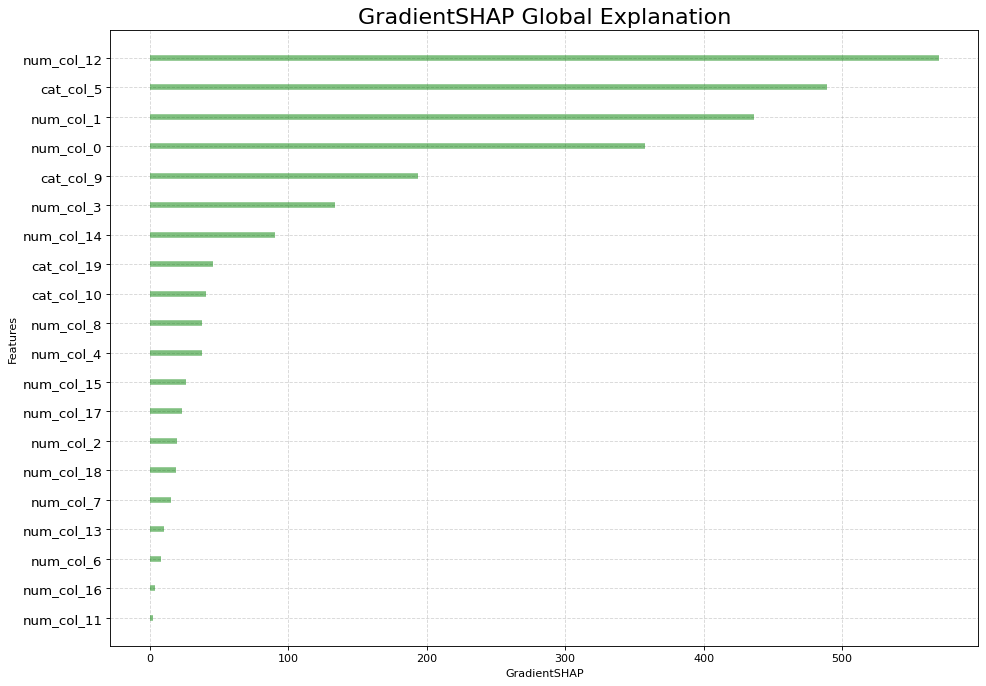

In [15]:
# Draw plot
plt.figure(figsize=(14, 10), dpi=80)

# Plotting the horizontal lines
plt.hlines(
    y=exp_agg.index,
    linewidth=5,
    xmin=0,
    xmax=exp_agg.GradientSHAP,
    colors=exp_agg.colors.values,
    alpha=0.5,
)
# Decorations
# Setting the labels of x-axis and y-axis
plt.gca().set(ylabel="Features", xlabel="GradientSHAP")

# Setting Date to y-axis
plt.yticks(exp_agg.index, exp_agg.Features, fontsize=12)

# Title of Bar Chart
plt.title("GradientSHAP Global Explanation", fontdict={"size": 20})

# Optional grid layout
plt.grid(linestyle="--", alpha=0.5)

# Displaying the Diverging Bar Chart
plt.show()